### Model Info: loss: 
Data: Grid

ImageDataGenerator( \
    rescale=1. / 255, \
    shear_range=0.2, \
    rotation_range=90, \
    zoom_range=[0.5, 1.5], \
    horizontal_flip=True)
    
batch_size = 16 \
image_width = 256 \
image_height = 256 
    
optimizer = adam

difference is in model structure -- follows page 216 of book

In [10]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

from keras.preprocessing.image import ImageDataGenerator

import datetime, os
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [2]:
train_path = 'grid_wildfire_smoke/train'
test_path = 'grid_wildfire_smoke/test'

In [3]:
#apply image augmentation
train_image_generator = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    rotation_range=90,
    zoom_range=[0.5, 1.5],
    horizontal_flip=True)
    
test_image_generator = ImageDataGenerator(rescale=1./255)

In [4]:
# Variables for model
batch_size = 16
image_width = 256  # diverging from book with height and width (set to 180 there)
image_height = 256 
classes = ['no_smoke','smoke']
color_mode="rgb"
IMAGE_WIDTH_HEIGHT = (image_width, image_height)

class_mode = 'binary'

#create train data generator flowing from train_input_folder
train_generator = train_image_generator.flow_from_directory(
            train_path,
            target_size=IMAGE_WIDTH_HEIGHT,
            batch_size=batch_size,
            classes=classes,
            color_mode=color_mode,
            class_mode=class_mode)
            
#create validation data generator flowing from test_input_folder
test_generator = test_image_generator.flow_from_directory(
        test_path,
        target_size=IMAGE_WIDTH_HEIGHT,
        batch_size=batch_size,
        classes=classes,
        color_mode=color_mode,
        class_mode=class_mode)

Found 2502 images belonging to 2 classes.
Found 2468 images belonging to 2 classes.


In [5]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
import matplotlib.pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

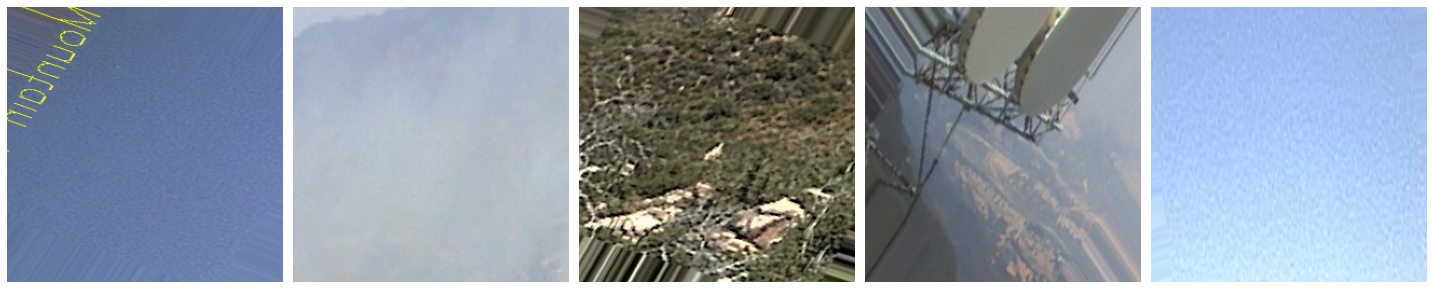

In [6]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:100])

In [7]:
input_shape = (image_width, image_height, 3)

In [8]:
model = Sequential()

model.add(Conv2D(32, 
                 kernel_size=(3, 3), 
                 activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu')) # diverging from book with this dense and dropout
model.add(Dropout(0.5))

# output layer - binary // sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',         # diverging from book with this adam instead of rmsprop
              metrics=['accuracy'])

2022-04-06 02:40:43.895282: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
epochs = 10
steps_per_epoch = train_generator.n // train_generator.batch_size
test_steps = test_generator.n // test_generator.batch_size

logdir = os.path.join("tf_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=test_generator,
      validation_steps=test_steps,
      epochs=epochs,
      callbacks=[tensorboard_callback])

Epoch 1/10
156/156 [==============================] - 276s 2s/step - loss: 0.5471 - accuracy: 0.6742 - val_loss: 0.4407 - val_accuracy: 0.7569
Epoch 2/10
156/156 [==============================] - 307s 2s/step - loss: 0.4049 - accuracy: 0.7949 - val_loss: 0.3476 - val_accuracy: 0.8291
Epoch 3/10
156/156 [==============================] - 307s 2s/step - loss: 0.3510 - accuracy: 0.8467 - val_loss: 0.3271 - val_accuracy: 0.9010
Epoch 4/10
156/156 [==============================] - 271s 2s/step - loss: 0.3110 - accuracy: 0.8733 - val_loss: 0.2767 - val_accuracy: 0.8851
Epoch 5/10
156/156 [==============================] - 274s 2s/step - loss: 0.4000 - accuracy: 0.8431 - val_loss: 0.2778 - val_accuracy: 0.8835
Epoch 6/10
156/156 [==============================] - 306s 2s/step - loss: 0.2958 - accuracy: 0.8902 - val_loss: 0.2458 - val_accuracy: 0.9196
Epoch 7/10
156/156 [==============================] - 272s 2s/step - loss: 0.2916 - accuracy: 0.8825 - val_loss: 0.2394 - val_accuracy: 0.9160

Text(0.5, 0, 'epoch')

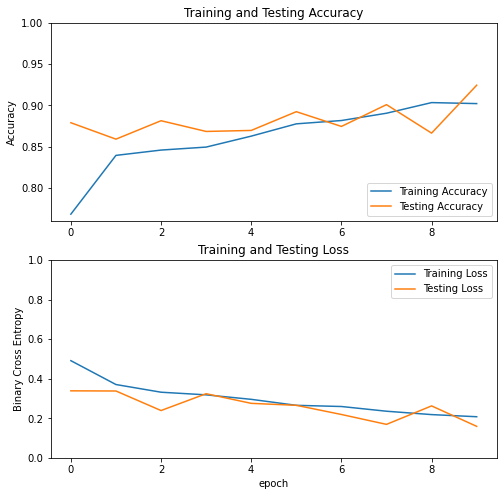

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Testing Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Testing Loss')
plt.xlabel('epoch')

In [14]:
# %load_ext tensorboard

In [26]:
# !pip uninstall -y tensorboard tb-nightly
# !pip install tb-nightly

In [29]:
tensorboard --logdir=20220406-021651/ --load_fast true